In [120]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# For GECCO formatting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

# Different length of backoff

1
2
3
4
5
6
7
8


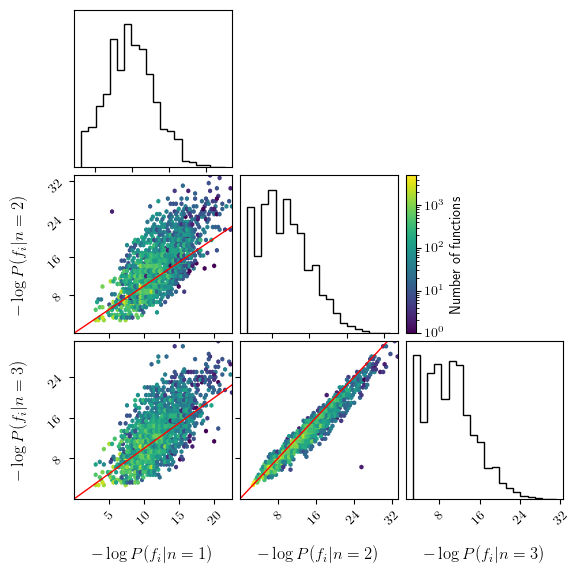

In [127]:
dirname = '../../ESR/esr/function_library/core_maths/'
all_p = [[], [], []]

for c in range(1, 9):
    
    print(c)

    logpar = np.loadtxt(dirname + f'compl_{c}/logconst_{c}.txt')
    
    for i in range(len(all_p)):
        p = np.loadtxt(dirname + f'compl_{c}/katz_codelen_{i+1}_{c}.txt')
        p -= logpar
        all_p[i] += list(p)
      
# Get finite values only
all_p = np.array(all_p, dtype=float)
m = np.ones(all_p.shape[1], dtype=bool) 
for i in range(all_p.shape[0]):
    m *= np.isfinite(all_p[i])
all_p = all_p[:,m]

labs = [f'$- \log P (f_i | n={i+1})$' for i in range(all_p.shape[0])]
    
fig, axs = plt.subplots(all_p.shape[0], all_p.shape[0], figsize=(6,6))

corner.corner(all_p.transpose(),
            labels=labs,
            fig=fig,
            label_kwargs={'fontsize':12},
            plot_contours=False,
            plot_density=False,
            plot_datapoints=False)

bins = np.logspace(0, np.log10(all_p.shape[1]))

for i in range(all_p.shape[0]-1):
    for j in range(i+1, all_p.shape[0]):
        hb = axs[j,i].hexbin(all_p[i,:], all_p[j,:], mincnt=1, gridsize=50, bins='log')
        x = axs[j,i].get_xlim()
        axs[j,i].plot(x, x, color='r', lw=1)

ax2_divider = make_axes_locatable(axs[-2,-1])
cax2 = ax2_divider.append_axes("left", size="7%", pad="2%")
cb = fig.colorbar(hb, cax=cax2, orientation="vertical")
cb.set_label(r'Number of functions')

fig.savefig('../figs/backoff_length.pdf', bbox_inches='tight', transparent=True)
        